Here:
- generate time series (cont OU process?)
- plot it (continious and also binned)
- calculate acf: using ABC tau, using py functions
- plot acf

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # comment this line if you don't want to use seaborn for plots

import numpy as np
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# add the path to the abcTau package
import sys
#sys.path.append('./abcTau')
sys.path.append('C:\\Users\\ipochino\\.conda\\envs\\isttc\\Lib\\site-packages\\abcTau') # IP: replaced previous line with that; relative path was not working
import abcTau

In [2]:
def OU_gen(tau, D, deltaT, T, numTrials):
    """Generate an OU process with a single timescale, zero mean and unit variance.

    Parameters
    -----------
    tau : float
        timescale.
    D : float
        diffusion parameter.
    deltaT : float
        temporal resolution for the OU process generation.    
    T : float
        duration of trials.
    numTrials : float
        number of trials.
    
    
    Returns
    -------
    ou : nd array
        array of generated OU process (numTrials * (T/deltaT)).
    """
    
    numBin = int(T/deltaT)
    noise =  np.random.normal(loc=0,scale=1, size=(numTrials,numBin))
    ou = np.zeros((numTrials,numBin))
    ou[:,0] = noise[:,0]
    for iBin in range(1,numBin):
        ou[:,iBin]  = ou[:,iBin-1] - (ou[:,iBin-1]/tau) * deltaT + np.sqrt(2*D*deltaT) * noise[:,iBin-1]
        
    return ou
# IP comments:
# 1. not sure why we multiply by deltaT in diffusion part - the finer the resolution (higher numBin) the less diffusion we have - this sort 
# of make sense

### Generate time series

In [105]:
tau = np.array([100])
D = 1/tau
deltaT = 1
T = 1000
numTrials = 1

# generate OU
#ou_all = OU_gen(tau, D, deltaT, T, numTrials)

In [106]:
# generate OU
numBin = int(T/deltaT)
print('numBin:', numBin)

noise =  np.random.normal(loc=0,scale=1, size=(numTrials,numBin))
print('noise.shape: ', noise.shape)

noise_ou = np.sqrt(2*D*deltaT) * noise
print('noise_ou.shape: ', noise_ou.shape)

ou = np.zeros((numTrials,numBin))
ou[:,0] = noise[:,0]
for iBin in range(1,numBin):
    ou[:,iBin]  = ou[:,iBin-1] - (ou[:,iBin-1]/tau) * deltaT + np.sqrt(2*D*deltaT) * noise[:,iBin-1]

print('ou.shape: ', ou.shape)

numBin: 1000
noise.shape:  (1, 1000)
noise_ou.shape:  (1, 1000)
ou.shape:  (1, 1000)


In [107]:
# adjust OU process - scale, shift and rectify (to get time-varying rate)

data_mean = 1 # average of firing rate
data_var = 1.5 # variance of firing rate

ou_check = np.max(ou)
print(ou_check)

ou_std = np.sqrt(data_var)
ou_mean = data_mean
ou_all = ou_std * ou + ou_mean # this is scale and shift, where is rectify?

print('ou_all.shape: ', ou_all.shape)

1.8880370270764724
ou_all.shape:  (1, 1000)


In [108]:
binSize = 50 # bins size for binning the data for calculating acf
binsData =  np.arange(0, T + binSize, binSize)
numBinData = len(binsData)-1
print(binsData)
print(numBinData)

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000]
20


In [109]:
new_shape = [numTrials, numBinData]
shape = (new_shape[0], ou_all.shape[0] // new_shape[0],
         new_shape[1], ou_all.shape[1] // new_shape[1])
print(shape)
binned_data = ou_all.reshape(shape).sum(-1).sum(1)
print(binned_data.shape)

(1, 1, 20, 50)
(1, 20)


In [110]:
binned_data = ou_all.reshape(shape).sum(-1).sum(1)
binned_data.shape
binned_data[0]

array([ 86.08820887,  90.38237366,  98.97455147,  28.58063135,
       -13.88568135,  14.41379314,  14.25939013,  78.37050807,
        73.33125962,   7.93495859,  81.76257127,  58.62108095,
        40.07974628, 124.14624567, 104.74423093,  20.45685576,
        28.1217212 ,  97.71956892,  42.18509678,  82.15543267])

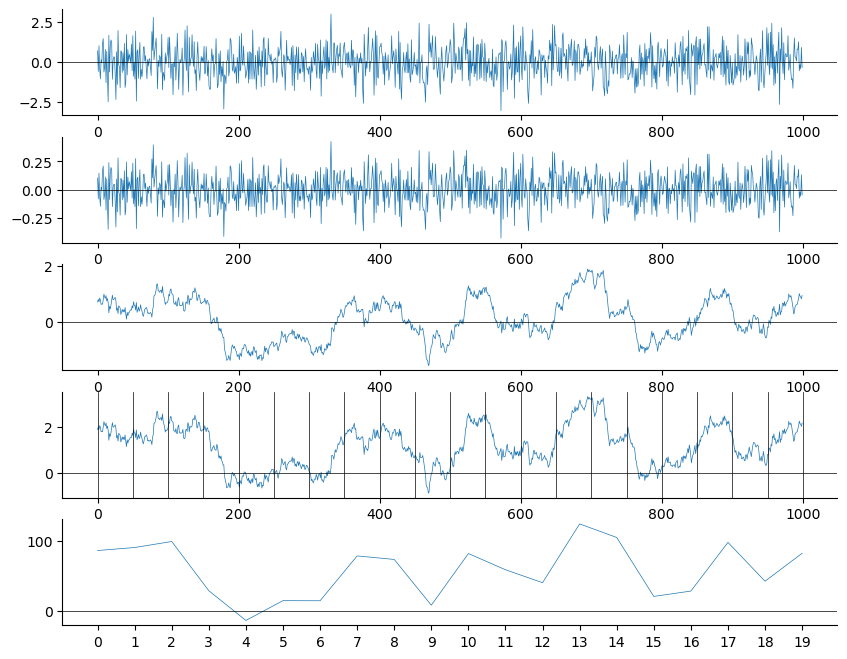

In [111]:
fig, axes = plt.subplots(5,1, figsize=(10,8))

axes[0].plot(np.linspace(0,numBin-1,numBin), noise[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)

axes[1].plot(np.linspace(0,numBin-1,numBin), noise_ou[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)

axes[2].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)

axes[3].plot(np.linspace(0,numBin-1,numBin), ou_all[0], lw=0.5)
axes[3].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[3].axvline(x=50*i, color='k', lw=0.5)

# that is supposed to be binned rate but it goes negative? is it ok?
axes[4].plot(np.linspace(0,numBinData-1,numBinData), binned_data[0], lw=0.5)
axes[4].axhline(y=0, color='k', lw=0.5)
axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))

sns.despine()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

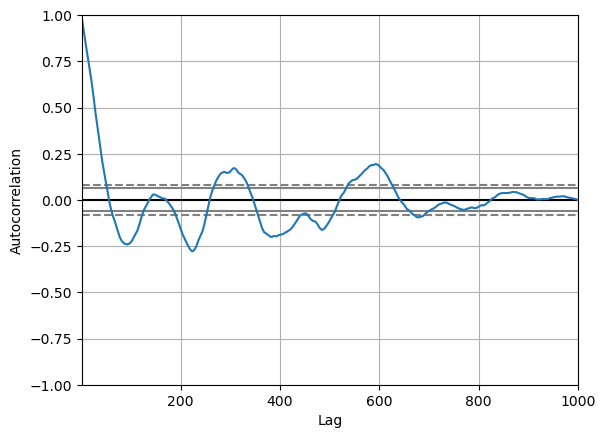

In [112]:
pd.plotting.autocorrelation_plot(ou_all[0,:])

In [114]:
#binSize = 50
maxTimeLag = 1000 
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(ou_all, deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print(data_sumStat)

[ 1.          0.17212524 -0.22321832 -0.01968603 -0.29821077 -0.13713143
  0.28925508 -0.04499377 -0.40838645 -0.22285372 -0.14205232  0.27277222
  0.60064553  0.06522509 -0.23399866 -0.23225175 -0.21602116 -0.00740822
  0.02992431  0.        ]


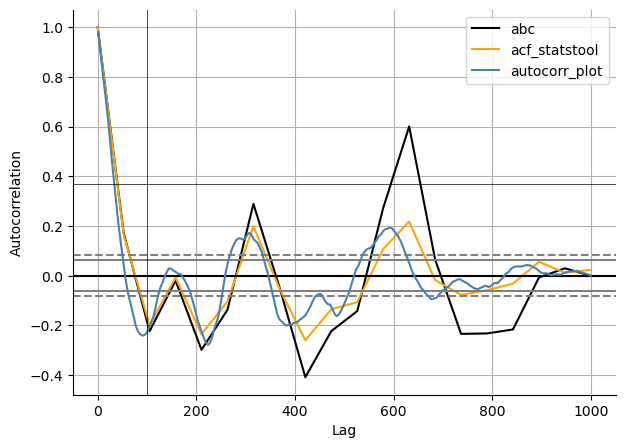

In [127]:
t_axis_lags = np.linspace(0, 1000, 20)

fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(t_axis_lags, data_sumStat, c='k', label='abc')
axes.plot(t_axis_lags, acf_, c='orange', label='acf_statstool')
pd.plotting.autocorrelation_plot(ou_all[0,:], ax=axes, c='steelblue', label='autocorr_plot')
#pd.plotting.autocorrelation_plot(ou[0,:], ax=axes, c='darkblue', label='autocorr_plot')
axes.axvline(x=100, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')

sns.despine()

In [121]:
from statsmodels.tsa.stattools import acf
acf_ = acf(binned_data[0], nlags=20)

In [133]:
popt, poptcov = abcTau.preprocessing.fit_oneTauExponential(data_sumStat, binSize, maxTimeLag)
tau = popt[1]

print(popt)

[1. 1.]


In [132]:
from scipy.optimize import curve_fit
def func_exp(x, a, b, c):
    """
    Exponential function to fit the data.
    :param x: 1d array, independent variable
    :param a: float, parameter to fit
    :param b: float, parameter to fit
    :param c: float, parameter to fit
    :return: callable
    """
    return a * np.exp(-b * x) + c
    
popt, pcov = curve_fit(func_exp, np.linspace(0,20,20), acf_[0:], maxfev=5000)
print(popt)

tau = 1 / popt[1]
tau_ms = tau * binSize
print(tau, tau_ms)

[ 1.0393456   1.85735234 -0.03553612]
0.5384008084346975 26.920040421734875


In [134]:
# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'linear_distance'

# Define a uniform prior distribution over the given range
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 100.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]

# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)

In [135]:
# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

In [145]:
# path for loading and saving data
datasave_path = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\'
inter_save_direc = datasave_path
inter_filename = 'inter_filename'

filename = 'test_1_trial'
filenameSave = filename

disp = None

In [146]:
# fit with aABC algorithm for any generative model
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc, inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

Starting step 0
epsilon = 1
acceptence Rate = 0.7751937984496124
--------------------
Starting step 1
epsilon = 0.15782721218119367
acceptence Rate = 0.5405405405405406
--------------------
Starting step 2
epsilon = 0.13743806735034375
acceptence Rate = 0.4
--------------------
Starting step 3
epsilon = 0.12045139498936173
acceptence Rate = 0.2570694087403599
--------------------
Starting step 4
epsilon = 0.10846125644059809
acceptence Rate = 0.2188183807439825
--------------------
Starting step 5
epsilon = 0.09450987452491855
acceptence Rate = 0.14144271570014144
--------------------
Starting step 6
epsilon = 0.08340199129509701
acceptence Rate = 0.09208103130755065
--------------------
Starting step 7
epsilon = 0.07736945593569948
acceptence Rate = 0.08064516129032258
--------------------
Starting step 8
epsilon = 0.07083657060137383
acceptence Rate = 0.0687757909215956
--------------------
Starting step 9
epsilon = 0.06480108673464495
acceptence Rate = 0.042265426880811495
---------

In [148]:
# extract estimated parameters
theta_accepted = abc_results[final_step-1]['theta accepted']
tau1 = theta_accepted[0]

In [149]:
tau1

array([  6.83564059,  54.22257936,  64.11224809,  57.21248199,
        26.32551166,  52.63346011,  35.32272085,  55.6269155 ,
        22.47751287, 104.54324744,  24.10315275,  30.25006849,
        36.54001095,  52.39436251,  16.13195189,  71.40782063,
         2.34201168,  72.84935733,  37.85367791,  64.08812797,
       121.61951015,  44.39059872,  36.90693695,  18.73298414,
        91.03094989,  96.96874064,  40.98922954,  64.16118542,
        98.15562811,  61.50105917,  47.48105307,  36.40909882,
        16.19342734,  12.33670005,  27.42825111,  35.50802118,
        28.77771627,  24.70413424,  17.19405553,  58.88260477,
        30.5159393 ,  48.17749217,  36.82656337,  25.73876796,
        34.53358816,  35.26489877,  89.23513303,  64.72620091,
        48.31083632,  25.74633102,  55.48399993,  28.73696416,
        24.38312502,  20.34668196, 105.05174794,  16.34394439,
        54.95606503,  74.39176591,  21.19810291,  17.14828238,
         5.27576316,  64.33998124,  22.45407633,  75.65

(array([0.00503029, 0.017606  , 0.01928277, 0.00838381, 0.01257572,
        0.01089895, 0.00419191, 0.00251514, 0.00251514, 0.00083838]),
 array([  2.34201168,  14.26976152,  26.19751137,  38.12526122,
         50.05301107,  61.98076091,  73.90851076,  85.83626061,
         97.76401045, 109.6917603 , 121.61951015]),
 <BarContainer object of 10 artists>)

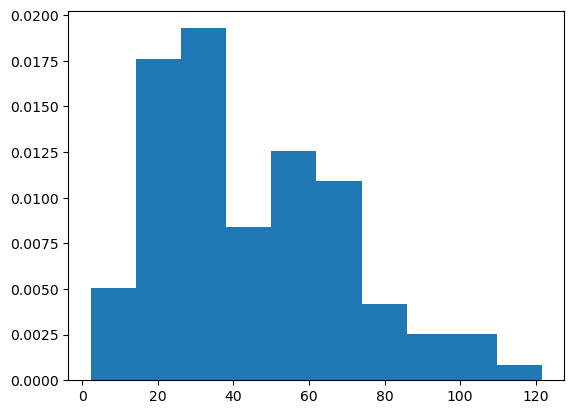

In [150]:
plt.hist(tau1, density=True, label = r'Estimated')